In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

path='images/images/'

# 
# read all files in train
train_files = os.listdir(path)
train_files = [f for f in train_files if f.endswith('.jpg')]

labels=[]

for f in train_files:
    label_splitted = f.split('_')
    if len(label_splitted) ==2:
        label = label_splitted[0]
    else:
        label = label_splitted[0] + '_' + label_splitted[1]
    labels.append(label)

In [2]:
len(labels)/37

199.72972972972974

In [3]:
import neptune



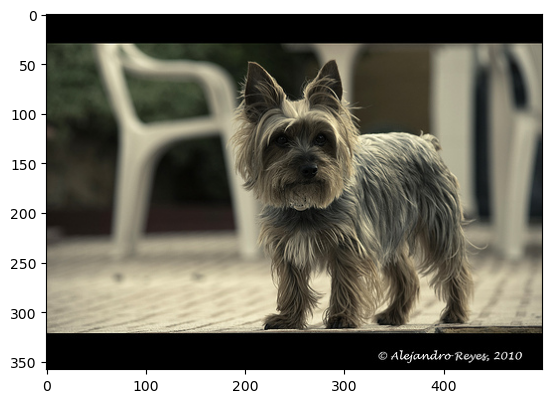

yorkshire_terrier


In [4]:


image= Image.open(path+train_files[-1])

plt.imshow(image)
plt.show()

print(labels[-1])

In [5]:
class_to_idx = {c:i for i,c in enumerate(np.unique(labels))}
idx_to_class = {i:c for c,i in class_to_idx.items()}

num_classes= len(class_to_idx)

In [6]:
class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [7]:
from joblib import Parallel, delayed
def load_image(file):
    image = Image.open(path + file)
    #reszie image to 224x224

    # convert to rgb
    if image.mode != 'RGB':
        image = image.convert('RGB')

    label_splitted = file.split('_')
    if len(label_splitted) ==2:
        y = label_splitted[0]
    else:
        y = label_splitted[0] + '_' + label_splitted[1]
    y=class_to_idx[y]
    y=torch.tensor(int(y), dtype=torch.long)
    return (image,y)

all_images= Parallel(n_jobs=16)(delayed(load_image)(f) for f in tqdm(train_files))

  0%|          | 0/7390 [00:00<?, ?it/s]

In [8]:
import torchvision.transforms as transforms

many_transforms= transforms.Compose([
    # horizontal flip
    transforms.RandomHorizontalFlip(),

    # random perspective
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    # random rotation
    transforms.RandomRotation(20),
    # change brightness, saturation, hue
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.03),
    # random perspective
    transforms.Resize((300, 300)),
    transforms.RandomCrop(224),
    transforms.ToTensor()
])


minimal_transforms= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

current_transforms = many_transforms

/home/bernd/anaconda3/envs/torch_linux/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bernd/anaconda3/envs/torch_linux/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [9]:

class Dataset:
    def __init__(self, images_and_labels, transforms=None):
        self.images_and_labels = images_and_labels
        self.size = len(images_and_labels)
        self.transforms=transforms
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        try:
            x,y=self.images_and_labels[idx]
            if self.transforms:
                x = self.transforms(x)
        except:
            print(f'Error at index {idx}, len of dataset is {self.size}') 
            raise
        return x, y

train_dataset = Dataset(all_images, transforms=current_transforms)
x, y = train_dataset[6000]
print(x.shape)

torch.Size([3, 224, 224])


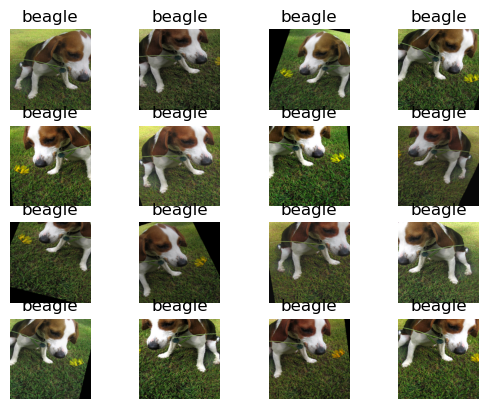

In [10]:
fig, ax= plt.subplots(4, 4)

for i in range(16):
    x,y=train_dataset[999]
    ax[i//4, i%4].imshow(x.permute(1,2,0))
    ax[i//4, i%4].set_title(idx_to_class[y.item()])
    ax[i//4, i%4].axis('off')
plt.show()

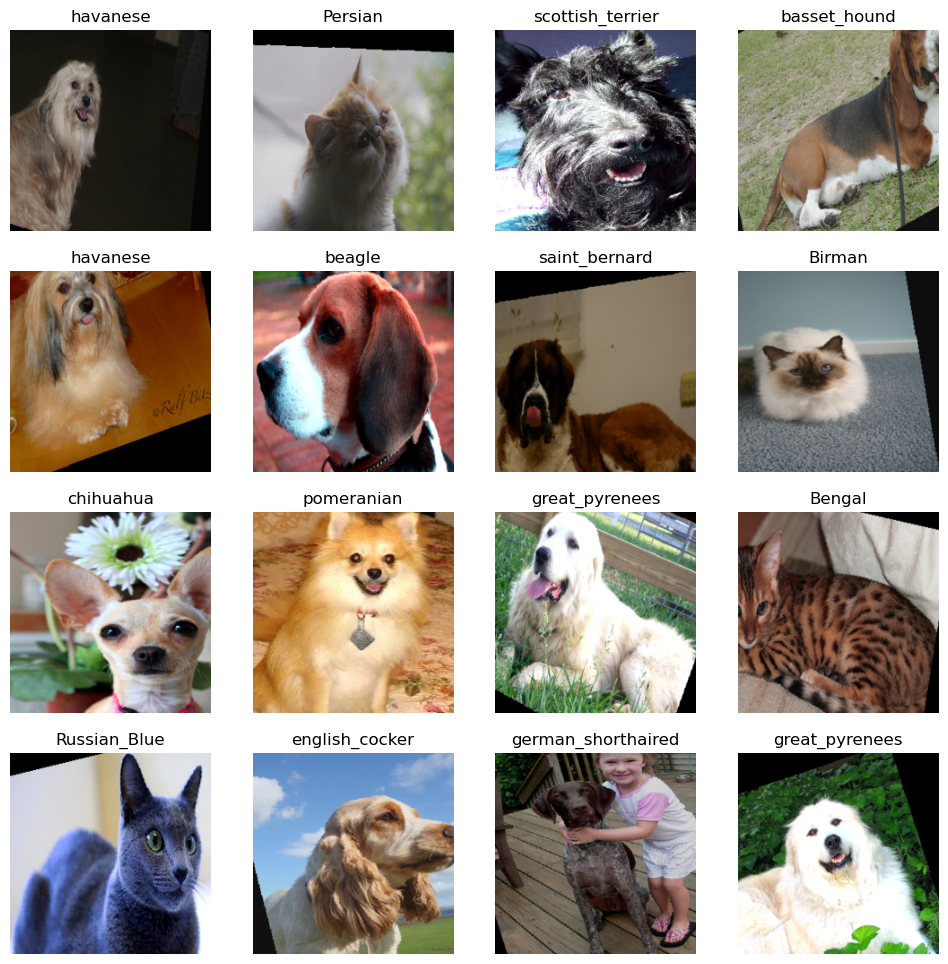

In [11]:
sample_loader= torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

fig, ax= plt.subplots(4,4, figsize=(12,12))
for x,y in sample_loader:
    for i in range(16):
        xi= x[i].permute(1,2,0).numpy()
        ax[i//4, i%4].imshow(xi)
        ax[i//4, i%4].set_title(idx_to_class[y[i].item()])
        #remove axis
        ax[i//4, i%4].axis('off')
    break

In [12]:
import torchvision
from torchvision.models import ResNet18_Weights

class CatsAndDogsModel(torch.nn.Module):
    def __init__(self, hidden_size=None, dropout=0.4):
        super().__init__()
        self.backbone=torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone.fc=torch.nn.Sequential(
            torch.nn.Linear(512, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.Linear(hidden_size, num_classes)
        )
        self.freeze()

    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad=False
        for param in self.backbone.fc.parameters():
            param.requires_grad=True

    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad=True
 
    def forward(self, x):
        x=self.backbone(x)
        return x
    
# wir bauen das Modell
model=CatsAndDogsModel(hidden_size=1000)
# wir bauen das Dataset
dataset_sample=Dataset(all_images, transforms=current_transforms)
# wir bauen den DataLoader
loader=torch.utils.data.DataLoader(dataset_sample, batch_size=13, shuffle=True)
# ein einziges Batch-Beispiel wird aus dem Dataloader geladen
for xb, yb in loader:
    print(model(xb).shape)
    assert model(xb).shape==torch.Size([13, num_classes]), "Error: model(xb).shape!=torch.Size([13, 10])"
    break


torch.Size([13, 37])


In [13]:

# split data into train and validation, using 80% for training and 20% for validation
# shuffled
train_idxs=np.random.choice(range(len(all_images)), int(0.8*len(all_images)), replace=False)
train_images=[all_images[i] for i in train_idxs]
validation_images=[all_images[i] for i in range(len(all_images)) if i not in train_idxs]

train_dataset=Dataset(train_images, transforms=current_transforms)

import torchvision
valid_transforms= torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    #imagenet normalization
])

valid_dataset=Dataset(validation_images, transforms=valid_transforms)

In [14]:
print(len(train_dataset), len(valid_dataset))

5912 1478


In [15]:
def get_accuracy(model, dataset):
    loader=torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)   
            y_pred=model(xb)
            y_pred=torch.argmax(y_pred, dim=1)
            correct+=(y_pred==yb).sum().item()
            total+=len(yb)
    return correct/total

24


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/bernd.heidemann/fa22boxfordpets/e/FAB-73


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

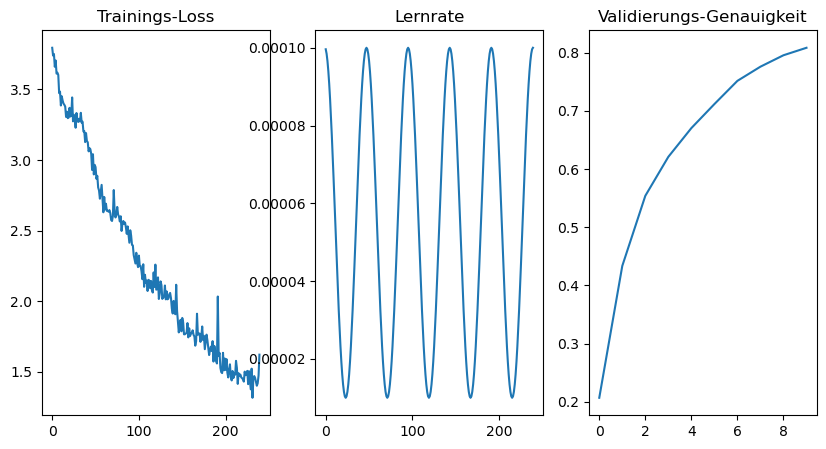

In [16]:
import neptune

torch.manual_seed(0)

lr=0.0001
batch_size=256
epochs=10
hidden_size=500

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

#device=torch.device('cpu')

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
valid_loader=torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
eval_steps=len(train_loader)
print(eval_steps)
model=CatsAndDogsModel(hidden_size).to(device)
#weight_decay: Hohe Gewichte werden bestraft, um Overfitting zu vermeiden
optimizer=torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)
#RMSprop: Optimierungsalgorithmus
#optimizer=torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=0.0001)
# OneCycleLR: Lernrate wird während des Trainings erhöht und dann wieder verringert
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0.00001)

# CrossEntropyLoss: Klassifikationsproblem mit mehreren Klassen
loss_func=torch.nn.CrossEntropyLoss()


run = neptune.init_run(
    project="bernd.heidemann/fa22boxfordpets",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
)  # your credentials

losses=[]
valid_losses=[]
learning_rates=[]
accs=[]

best_acc=0
postfix={}
for i in range(epochs):
    model.train()
    bar= tqdm(train_loader, total=len(train_loader), leave=False)  
    bar.set_description(f"Epoch {i+1}/{epochs}")
    steps=0
    bar.set_postfix(postfix)
    for xb, yb in bar:
        steps+=1
        bar.update(1)
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()                   # Gradienten (Ableitungen) zurücksetzen
        pred=model(xb)                          # Forward-Propagation
        loss=loss_func(pred, yb)                # Loss berechnen
        loss.backward()                         # ableiten
        optimizer.step()                        # Gewichte aktualisieren
        losses.append(loss.item())              # Loss speichern
        run["train/loss"].log(loss.item())
        scheduler.step()                        # Lernrate aktualisieren
        learning_rates.append(scheduler.get_last_lr()[0])
        run["train/lr"].log(scheduler.get_last_lr()[0])
        if steps%eval_steps==0:
            acc=get_accuracy(model, valid_dataset)
            accs.append(acc)
            if acc>best_acc:
                best_acc=acc
                torch.save(model.state_dict(), 'best_model.pth')
           
            postfix={
                    'loss': sum(losses[-eval_steps:])/eval_steps,
                    'lr': scheduler.get_last_lr()[0], 
                    'val_accuracy': acc
                 }
            bar.set_postfix(postfix)
            run["val/accuracy"].log(acc)
            
            run["val/loss"].log(sum(losses[-eval_steps:])/eval_steps)
            
fig, ax=plt.subplots(1,3, figsize=(10,5))
ax[0].plot(losses)
ax[0].set_title('Trainings-Loss')
ax[1].plot(learning_rates)
ax[1].set_title('Lernrate')
ax[2].plot(accs)
ax[2].set_title('Validierungs-Genauigkeit')

plt.show()

In [17]:
get_accuracy(model, valid_dataset)

0.8085250338294994